# Data Analysis of News and Stock Prices

First we'll import all the libraries we'll need.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import plotly.graph_objects as go
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

## Reading in and Cleaning the Data Sets

Then we'll import our data sets. The dats sets are the news_dija_data set which includes the top 25 Reddit News headlines and dija_data set which includes the opening and closing of the Dow Jones stock over a period of time.

In [2]:
news_dija_data = pd.read_csv('combined_stock_data.csv')
djia_data = pd.read_csv('upload_DJIA_table.csv')

Next, we'll clean up our news_dija_data set. There may be some rows that are null and some that aren't strings so we have to conver them. Also, the data set comes with the letter 'b' at the beginning of every healine so we have to remove that.

In [3]:
# clean null rows
news_dija_data = news_dija_data.dropna()

# convert all rows to strings
news_dija_data = news_dija_data.apply(lambda x: x.map(lambda y: str(y)), axis=1) 

# remove b characters
news_dija_data = news_dija_data.apply(lambda x: x.map(lambda y: y.replace('b"', '').replace
                                                      ("b'", '').replace('"', '')), axis=1)

## Combining the Data Sets

We now will merge our news_dija_data and our dija_data sets so that we only have to work with one data set for easy analysis. We chose various columns from news_dija_data to push to the end of dija_data.

In [4]:
combined_df = news_dija_data[['Date', 'Label', 'Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']].merge(
    djia_data, how='inner', on='Date', left_index=True)

In [5]:
columns = list(combined_df)
columns.append(columns.pop(columns.index('Label')))
combined_df = combined_df.loc[:, columns]
combined_df.head()

,Date,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,Label
1988,2008-08-08,75.0,25.0,18.75,56.25,25.0,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,0
1987,2008-08-11,83.3333333333,16.6666666667,41.6666666667,41.6666666667,16.6666666667,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,1
1986,2008-08-12,56.25,43.75,18.75,37.5,43.75,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,0
1985,2008-08-13,38.4615384615,61.5384615385,15.3846153846,23.0769230769,61.5384615385,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,0
1984,2008-08-14,45.4545454545,54.5454545455,36.3636363636,9.090909090910001,54.5454545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,1


In [6]:
combined_df['Volume'] = combined_df['Volume'].astype(float)
combined_df['Subjectivity'] = combined_df['Subjectivity'].astype(float)
combined_df['Objectivity'] = combined_df['Objectivity'].astype(float)
combined_df['Positive'] = combined_df['Positive'].astype(float)
combined_df['Negative'] = combined_df['Negative'].astype(float)
combined_df['Neutral'] = combined_df['Neutral'].astype(float)
combined_df['Label'] = combined_df['Label'].astype(float)

combined_df.index = combined_df.index.sort_values()
combined_df.describe()
combined_df.head()

,Date,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,Label
0,2008-08-08,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000.0,11734.320312,0.0
1,2008-08-11,83.333333,16.666667,41.666667,41.666667,16.666667,11729.669922,11867.110352,11675.530273,11782.349609,183190000.0,11782.349609,1.0
2,2008-08-12,56.250000,43.750000,18.750000,37.500000,43.750000,11781.700195,11782.349609,11601.519531,11642.469727,173590000.0,11642.469727,0.0
3,2008-08-13,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000.0,11532.959961,0.0
4,2008-08-14,45.454545,54.545455,36.363636,9.090909,54.545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000.0,11615.929688,1.0


In [7]:
train = combined_df[combined_df['Date'] < '2015-01-01']
test = combined_df[combined_df['Date'] > '2014-12-31']

## Finding the Correlation Between Variables

We will be finding the correlation between news article sentiment variables and stock price variables.

### Finding the Correlation Between a News Article with Negative Sentiment and the Opening Dow Jones Price

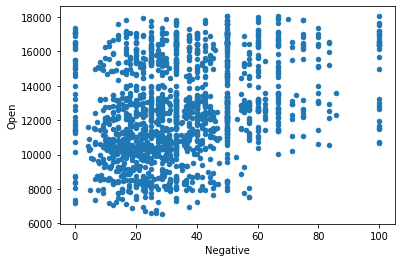

In [8]:
train.plot.scatter(x="Negative", y="Open")

We can see from this scatterplot that the opening price goes up as the negative sentiment of the news headlines goes up.

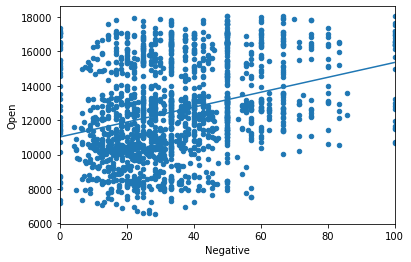

In [9]:
X_train = train[["Negative"]]
X_test = test[["Negative"]]
y_train = train["Open"]

model = LinearRegression()
model.fit(X=X_train, y=y_train)
model.predict(X=X_test)

X_new = pd.DataFrame()

X_new["Negative"] = np.linspace(0, 100, num=250)

y_new = pd.Series(
    model.predict(X_new),
    index=X_new["Negative"]
)

train.plot.scatter(x="Negative", y="Open")
y_new.plot.line()

The same thing that was revealed in the first scatterplot is revealed in the above scatterplot. We can see from this scatterplot that the opening price goes up as the negative sentiment of the news headlines goes up.

### Finding the Correlation Between a News Article with Positive Sentiment sna the Opening Dow Jones Price

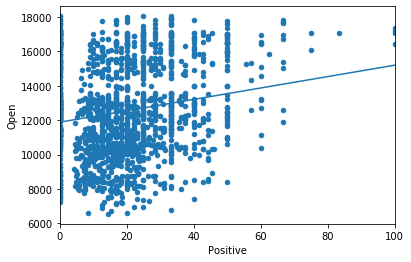

In [10]:
X_train = train[["Positive"]]
X_test = test[["Positive"]]
y_train = train["Open"]

model = LinearRegression()
model.fit(X=X_train, y=y_train)
model.predict(X=X_test)

X_new = pd.DataFrame()

X_new["Positive"] = np.linspace(0, 100, num=250)

y_new = pd.Series(
    model.predict(X_new),
    index=X_new["Positive"]
)

train.plot.scatter(x="Positive", y="Open")
y_new.plot.line()

We can also see from this scatterplot that the opening price goes up as the positive sentiment of the news headlines goes up.

### Finding the Correlation Between a News Article with Neutral Sentiment and the Opening Dow Jones Price

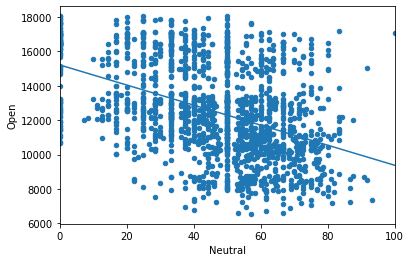

In [11]:
X_train = train[["Neutral"]]
X_test = test[["Neutral"]]
y_train = train["Open"]

model = LinearRegression()
model.fit(X=X_train, y=y_train)
model.predict(X=X_test)

X_new = pd.DataFrame()

X_new["Neutral"] = np.linspace(0, 100, num=250)

y_new = pd.Series(
    model.predict(X_new),
    index=X_new["Neutral"]
)

train.plot.scatter(x="Neutral", y="Open")
y_new.plot.line()

We can see that this scatterplot is different from the two previous scatterplots. As we can see the opening price actually goes down as the news sentiment goes up in neutrality. This is interesting brcause this suggests that stocks ony go up when news is on the extreme sites of the spectrum in terms of negative and positive sentiment.

### Finding the Correlation Between All Variables

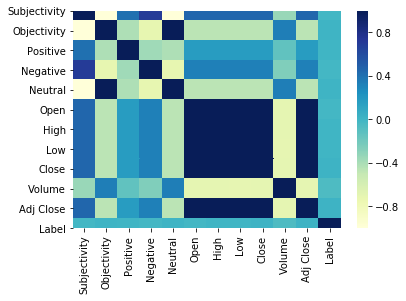

In [12]:
corr = combined_df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,cmap="YlGnBu")

From this correlation heatmap, we can clearly see what variables are correlated. From looking at this we can see that the subjective news sentiment has the greatest effect on the stock price with negative following then positive, objectivity, and then neutrality.

## Training and Testing Headlines

We will be finding which words within the headlines have the highest and lowest coefficients.

In [13]:
train = news_dija_data[news_dija_data['Date'] < '2015-01-01']
test = news_dija_data[news_dija_data['Date'] > '2014-12-31']

In [14]:
trainingheadlines = []
for row in range(0,len(train.index)):
    trainingheadlines.append(' '.join(str(x) for x in train.iloc[row,2:27]))

In [15]:
initialvectorizer = CountVectorizer()
initialtrain = initialvectorizer.fit_transform(trainingheadlines)
print(initialtrain.shape)

(1608, 31114)


In [16]:
initialmodel = LogisticRegression()
initialmodel = initialmodel.fit(initialtrain, train["Label"])

/Users/cristinalawson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [17]:
testingheadlines = []
for row in range(0,len(test.index)):
    testingheadlines.append(' '.join(str(x) for x in test.iloc[row,2:27]))
initialtest = initialvectorizer.transform(testingheadlines)
initialpredictions = initialmodel.predict(initialtest)

378


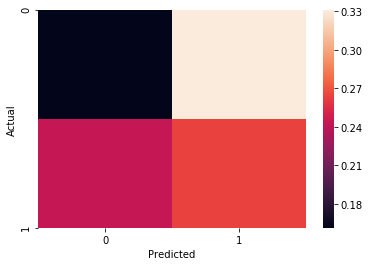

In [18]:
counts = pd.crosstab(test["Label"], initialpredictions, rownames=["Actual"], colnames=["Predicted"])
counts
print(counts.sum().sum())
joint = counts / counts.sum().sum()
joint
sns.heatmap(joint)

In [19]:
initialwords = initialvectorizer.get_feature_names()
initialcoeffs = initialmodel.coef_.tolist()[0]
coeffs_df = pd.DataFrame({'Word' : initialwords,'Coefficient' : initialcoeffs})
coeffs_df = coeffs_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
coeffs_df.head(10)

,Word,Coefficient
15582,kills,0.528035
25859,so,0.475022
28772,tv,0.462943
19071,nigeria,0.449722
28742,turn,0.415155
15734,korea,0.413472
19773,olympics,0.410356
27778,territory,0.401286
24819,self,0.399448
28608,troops,0.396639


These are the words with the highest coefficients.

In [20]:
coeffs_df.tail(10)

,Word,Coefficient
6585,congo,-0.436430
26817,students,-0.439945
26158,speech,-0.449215
16662,low,-0.449539
24324,sanctions,-0.491120
24113,run,-0.504891
7036,country,-0.514576
24988,sex,-0.519301
24681,sea,-0.521224
3596,begin,-0.532128


These are the words with the lowest coefficients.

## Testing and Training Model

Setting up the training and testing data sets to be passed into the machine learning models.

In [21]:
list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']

for col in list:
    combined_df[col] = combined_df[col].fillna(combined_df[col].mean())
    
X = combined_df.loc[:,'Subjectivity':'Adj Close']
y = combined_df.loc[:,'Label']

validation_size = 0.35
trainSize = int(len(X.index) * 0.7)

X_train = X.loc[0:trainSize, :] 
X_test = X.loc[trainSize: len(X.index), :]
y_train = y[0:trainSize]
y_test = y.loc[trainSize: len(X.index)]

## Machine Learning Models

We will be determining which machine learning model is the most accurate.

### Logistic Regression

In [22]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print('LogisticRegression' + ": " + str(score))

LogisticRegression: 0.5294117647058824


### K-Nearest Neighbor

In [23]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print('KNeighborsClassifier' + ": " + str(score))

KNeighborsClassifier: 0.4588235294117647


### Random Forest Classifier

In [24]:
model = RandomForestClassifier(n_estimators=50)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print('RandomForestClassifier' + ": " + str(score))

RandomForestClassifier: 0.5815126050420169


### SGD(Stochastic Gradient Descent) Classifier

In [25]:
model = SGDClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print('SGDClassifier' + ": " + str(score))

SGDClassifier: 0.47058823529411764


We can see that the Random Forest Classifier has the highest accuracy.

## Conclusion

We can see that there is no clear correlation between the sentiment of the news healines and the prices of the stock. This may be beacuse the stock market is unpredictable and many people have different reasons for buying and selling. Some reasons I have behind this are that when there is good news a lot of people sell thinking that it's the peak, and many people buy thinking it will go up further. When there is bad news many people sell thinking it is at its peak, and many people buy thinking that it is low and will go higher. This this causes them to be indistinguishable. In order to get more accurate analysis I believe we would have to do deeper analysis.